In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import utils

import os
import glob
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# 모델 가중치 저장할 폴더 생성
os.makedirs('.\\weights', exist_ok=True)

# 하이퍼파라메타 값 세팅
batch_size = 36
num_epochs = 10
val_every = 1 # 평가 간격
save_weights_dir = '.\\weights'
data_path = '.\\dataset'
nc = 5 # num_classes
lr = 0.025 # learning rate

In [3]:
# https://tutorials.pytorch.kr/beginner/finetuning_torchvision_models_tutorial.html

def initialize_model(model_name, num_classes, use_pretrained=True):
    
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        # Resnet18
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        # Alexnet
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        # VGG11_bn
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        # Squeezenet
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_path, mode, transform=None):
        # init : 초기값 설정
        # 데이터 가져오기 전체 데이터 경로 불러오기
        self.all_data = sorted(glob.glob(os.path.join(data_path, mode, '*', '*.jpg')))
        # data_path > .\\dataset\\train * -> DownDog *.jpg -> 000000.jpg
        self.transform = transform

        paths = sorted(glob.glob(os.path.join(data_path, mode, '*')))
        self.labels = [path.split('\\')[-1] for path in paths]
        self.train_dict = {label: sorted(glob.glob(os.path.join(data_path, 'train', label, '*.jpg')))
                           for label in self.labels}
        self.valid_dict = {label: sorted(glob.glob(os.path.join(data_path, 'val', label, '*.jpg')))
                           for label in self.labels}

    def __getitem__(self, index):
        data_path = self.all_data[index]
        # print('data_path info >> ', data_path)
        data_path_split = data_path.split('\\')
        # data_path_split info >>  ['.\\dataset\\train\\Downdog\\00000000.jpg']
        # data_path_split info >>  ['.', 'dataset', 'train', 'Downdog', '00000000.jpg']
        labels_temp = data_path_split[3]
        # labels_temp info >> Downdog

        # label = 0
        # if 'Downdog' == labels_temp:
        #     label = 0
        # elif 'Goddess' == labels_temp:
        #     label = 1
        # elif 'Plank' == labels_temp:
        #     label = 2
        # elif 'Tree' == labels_temp:
        #     label = 3
        # elif 'Warrior2' == labels_temp:
        #     label = 4

        images = Image.open(data_path).convert('RGB')

        if self.transform is not None:
            images = self.transform(images)

        return images, self.labels.index(labels_temp)

    def __len__(self):
        return len(self.all_data)

In [5]:
def data_augmentation():
    data_transform = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
        ])
    }
    return data_transform

In [6]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    history = []
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

In [7]:
def loss_acc_visualize(history, optim):
    plt.figure(figsize=(20, 10))

    plt.suptitle(str(optim))

    plt.subplot(121)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['valid_loss'], label='valid_loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(122)
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['valid_acc'], label='valid_acc')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()
    # plt.savefig(str(path) + 'loss_acc.png')

In [8]:
def visual_predict(model, data):
    c = np.random.randint(0, len(data))
    img, label = data[c]

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # out = model(img.view(1, 3, 224, 224).cuda())
        out = model(img.view(1, 3, 224, 224).cpu())
        out = torch.exp(out)
        print(out)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title(data.labels[label])
    plt.subplot(122)
    plt.barh(data.labels, out.cpu().numpy()[0])
    plt.show()

In [9]:
def class_accuracies(model, data):
    accuracy_dict = {}
    with torch.no_grad():
        model.eval()
        for c in data.valid_dict.keys():
            correct_count = 0
            total_count = len(data.valid_dict[str(c)])
            gt = data.labels.index(str(c))
            for path in data.valid_dict[str(c)]:
                # print(path)
                im = Image.open(path).convert('RGB')
                # im.show()
                im = transforms.ToTensor()(im)
                im = transforms.Resize((224, 224))(im)
                # out = model(im.view(1, 3, 224, 224).cuda())
                out = model(im.view(1, 3, 224, 224).cpu())
                # print(out)
                out = torch.exp(out)
                pred = list(out.cpu().numpy()[0])
                # print(pred)
                pred = pred.index(max(pred))
                # print(pred,gt)

                if gt == pred:
                    correct_count += 1
            print(f"Accuracy for class {str(c)} : ",
                  correct_count / total_count)
            accuracy_dict[str(c)] = correct_count / total_count

    plt.figure(figsize=(10, 5))
    plt.title('class_accuracies')
    plt.barh(list(accuracy_dict.keys()), list(accuracy_dict.values()))
    plt.show()

    return accuracy_dict

In [10]:
# 1. device 설정
# device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = torch.device('mps')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# 2. augmentation setting
data_transform = data_augmentation()

In [12]:
# 3. data set setting
train_data = CustomDataset(data_path=data_path, mode='train', transform=data_transform['train'])
test_data = CustomDataset(data_path=data_path, mode='val', transform=data_transform['test'])

In [13]:
# 4. data loader setting
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [14]:
# 5. model call
net, image_size = initialize_model('resnet', num_classes=nc)

In [15]:
# 6. 하이퍼파라메타 값 call loss function 호출, optim, lr_scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [16]:
# 7. train loop 함수 호출
# 8. test loop 함수 호출
# 과제 train loop 구성 하시면 됩니다.
model_ft, hist = train_model(
    net, {'train': train_loader, 'val': test_loader}, criterion, optimizer, lr_scheduler, num_epochs=num_epochs
)

Epoch 0/9
----------
train Loss: 0.8213 Acc: 0.6941
val Loss: 2.8365 Acc: 0.1863
Epoch 1/9
----------
train Loss: 0.6916 Acc: 0.8014
val Loss: 2.3139 Acc: 0.2745
Epoch 2/9
----------
train Loss: 0.4697 Acc: 0.8307
val Loss: 0.2892 Acc: 0.5882
Epoch 3/9
----------
train Loss: 0.3752 Acc: 0.8589
val Loss: 0.0162 Acc: 0.6961
Epoch 4/9
----------
train Loss: 0.1202 Acc: 0.9334
val Loss: 0.0059 Acc: 0.7059
Epoch 5/9
----------
train Loss: 0.0819 Acc: 0.9515
val Loss: 0.0041 Acc: 0.7059
Epoch 6/9
----------
train Loss: 0.0682 Acc: 0.9549
val Loss: 0.0020 Acc: 0.7059
Epoch 7/9
----------
train Loss: 0.0661 Acc: 0.9571
val Loss: 0.0010 Acc: 0.7059
Epoch 8/9
----------
train Loss: 0.0507 Acc: 0.9594
val Loss: 0.0012 Acc: 0.7059
Epoch 9/9
----------
train Loss: 0.0670 Acc: 0.9560
val Loss: 0.0011 Acc: 0.7059
Training complete in 12m 10s
Best val Acc: 0.705882


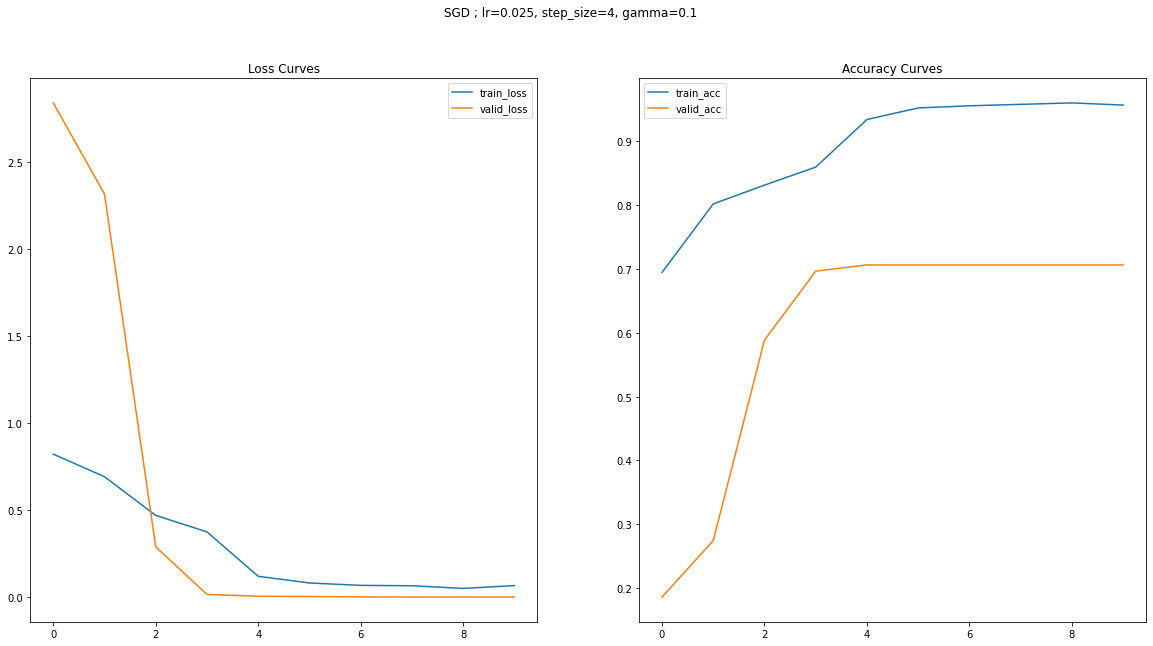

In [17]:
loss_acc_visualize(history=hist, optim=f'SGD ; lr={lr}, step_size=4, gamma=0.1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[3.0078e-02, 2.2215e-02, 1.0429e+07, 1.5311e-02, 3.2955e-03]])


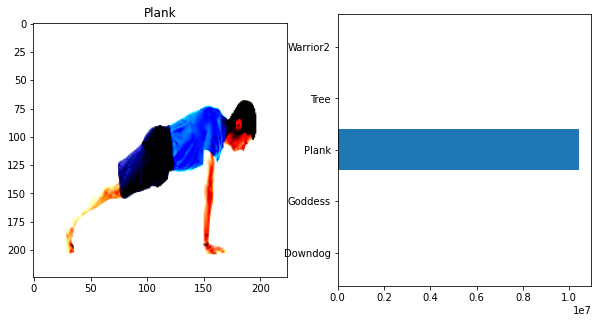

In [18]:
visual_predict(model=model_ft, data=test_data)

Accuracy for class Downdog :  0.95
Accuracy for class Goddess :  0.8095238095238095
Accuracy for class Plank :  0.9
Accuracy for class Tree :  0.7619047619047619
Accuracy for class Warrior2 :  0.3


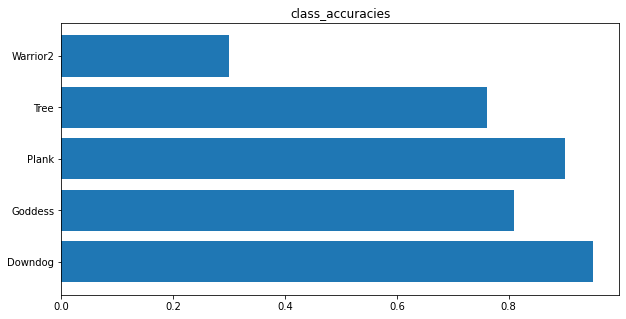

In [19]:
sgd_lr025_dict = class_accuracies(model=model_ft, data=test_data)